# Synthetic Controls for Wildfire Data in Italy

Apply synthetic control to see if the trend in area burned evolved differently in the independent regions who kept the Corpo Forestale, compared to all other regions where since 2017 the Carabinieri Forestali are the responsible authority.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import cvxpy as cp
import numpy as np
import os


from sklearn.linear_model import LinearRegression, HuberRegressor

import datetime


# time stamp in the format of 'YYYY-MM-DD'
PLOT_DIR = 'plots/'
os.makedirs(PLOT_DIR, exist_ok=True)
PAGE_WIDTH = 6.2677165  # page width in inches

# matplotlib set font size to 7 and font to Arial
plt.rc('font', size=7)
plt.rc('font', family='Arial')


def savefig(fig, name, path=PLOT_DIR):
    fig.savefig(os.path.join(path, f'{name}.pdf'), bbox_inches='tight')
    fig.savefig(os.path.join(path, f'{name}.png'), dpi=300, bbox_inches='tight')

def get_rmse(results, observed, regions, splits):
    return [np.sqrt(np.mean((results.loc[s][regions].values - observed.loc[s][regions].values)**2)) for s in splits]

def get_r2(results, observed, regions, splits):
    r2_values = []
    for s in splits:
        y_pred = results.loc[s][regions].values
        y_true = observed.loc[s][regions].values
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        r2_values.append(r2)
    return r2_values

def durbin_watson_test(residuals):
    """
    Perform the Durbin-Watson test for autocorrelation in the residuals.
    """
    n = len(residuals)
    residuals_diff = np.diff(residuals)
    dw_statistic = np.sum(residuals_diff**2) / np.sum(residuals**2)
    return dw_statistic

def ljung_box_q_test(residuals, lags=3):
    """
    Perform Ljung-Box Q test for autocorrelation in residuals.
    Returns a list of (lag, Q statistic, p-value) tuples.
    """
    import numpy as np
    from scipy.stats import chi2

    n = len(residuals)
    mean = np.mean(residuals)
    results = []

    # store autocorrelations
    acfs = []
    for lag in range(1, lags + 1):
        if n > lag:
            acf = np.corrcoef(residuals[:-lag], residuals[lag:])[0, 1]
        else:
            acf = np.nan
        acfs.append(acf)

    # compute cumulative Q statistics
    Q = 0.0
    for lag, acf in enumerate(acfs, start=1):
        if np.isnan(acf):
            results.append((lag, np.nan, np.nan))
            continue
        Q += n * (n + 2) * (acf ** 2) / (n - lag)
        p_value = 1 - chi2.cdf(Q, df=lag)
        results.append(p_value)

    return results
    

# 1) Data Preprocessing


In [2]:
YEARS_TRAIN = [*range(2003, 2015)]
YEARS_TEST = [*range(2015, 2017)]
YEARS_VAL = [*range(2017, 2022)]

YEARS = YEARS_TRAIN + YEARS_TEST + YEARS_VAL

In [3]:
def style_plot(ax, axhline=False, add_policy_change=False, ha='center'):
    testing_start = YEARS[-len(YEARS_VAL) - len(YEARS_TEST)] - 0.5
    validation_start = YEARS[-len(YEARS_VAL)] - 0.5

    if axhline:
        ax.axhline(0, color='k', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if add_policy_change:
        ax.axvline(validation_start, ymax=0.9, color='k', alpha=0.5, linestyle=':', linewidth=1)
        if add_policy_change != 'line':
            ax.text(validation_start,  0.98*ax.get_ylim()[1], 'policy intervention',color='k', va='top', ha=ha)

## Units (regions with and without intervention)

In [4]:
df_units = pd.read_csv('data/units/units.csv', index_col='REGION')
EXCLUDED = df_units[df_units['UNIT'] == 'EXCLUDE'].index.values.tolist()
TREATED = df_units[df_units['UNIT'] == 'TREATED'].index.values.tolist()
CONTROL = df_units[df_units['UNIT'] == 'CONTROL'].index.values.tolist()
df_units = df_units[df_units['UNIT'] != 'EXCLUDE']
df_units

print('EXCLUDED', ', '.join(EXCLUDED))
print('TREATED', ', '.join(TREATED))
print('CONTROL', ', '.join(CONTROL))

EXCLUDED Provincia Autonoma di Trento, Valle d'Aosta
TREATED Abruzzo, Puglia, Basilicata, Calabria, Campania, Emilia-Romagna, Lazio, Liguria, Lombardia, Marche, Molise, Piemonte, Toscana, Umbria, Veneto
CONTROL Friuli-Venezia Giulia, Sardegna, Sicilia


## Wildfire Weather Index (FWI) Data

In [5]:
df_fwi = pd.read_excel('data/fwi-data/fwi_italy.xlsx').drop(columns=['COD_REG']).set_index('DEN_REG').T.drop(index=[2000, 2001, 2002])
df_fwi.index.name = 'Year'
df_fwi.columns.name = ''
df_fwi.rename(columns={'Friuli Venezia Giulia': 'Friuli-Venezia Giulia'}, inplace=True)
df_fwi.index
df_fwi.index = df_fwi.index.astype('int64')
df_fwi

,Lazio,Basilicata,Lombardia,Abruzzo,Molise,Marche,Liguria,Valle d'Aosta,Umbria,Campania,Toscana,Piemonte,Calabria,Puglia,Veneto,Friuli-Venezia Giulia,Emilia-Romagna,Trentino-Alto Adige,Sicilia,Sardegna
Year,,,,,,,,,,,,,,,,,,,,
2003,27.426908,25.115397,13.787816,16.080087,18.082995,19.781920,12.911364,4.160089,30.111264,24.598085,26.328588,15.657132,17.258839,29.399497,13.366184,8.980524,19.992240,5.921261,25.604898,36.615643
2004,24.225173,25.398150,9.902623,16.104304,19.724951,18.513585,11.373371,2.812844,24.586883,22.345545,19.940827,12.404764,18.865505,28.562392,8.497840,3.562748,16.522883,2.646012,26.294245,34.345293
2005,18.970867,23.317251,4.774901,10.151734,13.658929,11.000148,5.934075,1.468739,18.329444,17.040773,14.964856,7.289956,17.875433,25.951212,4.015633,2.947999,9.390305,1.406954,28.256332,30.027763
2006,16.925445,20.434525,9.215379,11.953201,13.827907,14.230541,7.065422,2.068877,20.880746,14.445677,16.997856,11.650261,16.856752,23.175585,8.719512,6.813930,12.584549,3.416795,26.519465,29.565111
2007,26.545640,38.674474,9.666121,21.831714,31.423023,24.561388,12.254438,3.306491,27.883686,29.844499,20.059842,11.637439,26.945247,41.267860,7.031923,3.981853,18.530820,2.586365,33.814199,34.542015
2008,24.004651,32.905091,5.233944,17.186335,24.160778,22.561891,6.995674,1.532157,27.443567,25.004194,19.438575,7.087840,23.130115,36.966019,5.743389,3.485660,14.764617,1.469224,31.047838,31.983001
2009,19.700968,24.618136,8.543745,11.724699,16.327880,13.636130,8.960296,2.826562,19.899478,20.885318,19.741793,10.312987,19.485266,27.633688,8.622887,4.978497,15.375924,1.953381,27.463906,31.078426
2010,17.748734,22.165053,5.476206,10.670924,16.026777,11.178288,5.810979,1.686125,16.721026,16.214173,12.908554,6.635435,16.618331,27.510362,4.603939,3.533960,8.584401,1.906979,26.572844,29.064616
2011,20.523962,28.704336,6.761814,15.384355,20.120865,20.270542,9.030666,2.311156,21.061347,22.860270,18.415048,8.565739,24.393731,33.229651,8.518678,4.841631,18.596443,1.913366,30.852706,31.273766


In [6]:
# df_fwi = pd.read_csv('data/fwi-data/fwi_3mesi.csv', index_col='Year')
# df_fwi.index

In [7]:
df_fwi_eu = pd.read_excel('data/fwi-data/fwi_europe.xlsx', sheet_name='mean_summer_FWI').drop(columns={'iso3','iso_3166_1'}).set_index('name').T
df_fwi_eu.index.rename('year', inplace=True)
df_fwi_eu.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)
df_fwi_eu.rename(columns={'Italy ordinary regions': 'Italy TREATED'}, inplace=True)
df_fwi_eu.rename(columns={'Italy 3 autonomous regions': 'Italy CONTROL'}, inplace=True)

df_fwi_eu.drop(index=[2000, 2001, 2002], inplace=True)
df_fwi.index = df_fwi.index.astype('int64')
print(','.join(sorted(df_fwi_eu.columns)))
df_fwi


Albania,Andorra,Austria,Belarus,Belgium,Bosnia & Herzegovina,Bulgaria,Croatia,Cyprus,Czechia,Denmark,Estonia,Faroe Islands,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Italy CONTROL,Italy TREATED,Latvia,Liechtenstein,Lithuania,Luxembourg,Malta,Moldova, Republic of,Monaco,Montenegro,Netherlands,Norway,Poland,Portugal,Romania,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,The former Yugoslav Republic of Macedonia,Turkey,U.K. of Great Britain and Northern Ireland,Ukraine


,Lazio,Basilicata,Lombardia,Abruzzo,Molise,Marche,Liguria,Valle d'Aosta,Umbria,Campania,Toscana,Piemonte,Calabria,Puglia,Veneto,Friuli-Venezia Giulia,Emilia-Romagna,Trentino-Alto Adige,Sicilia,Sardegna
Year,,,,,,,,,,,,,,,,,,,,
2003,27.426908,25.115397,13.787816,16.080087,18.082995,19.781920,12.911364,4.160089,30.111264,24.598085,26.328588,15.657132,17.258839,29.399497,13.366184,8.980524,19.992240,5.921261,25.604898,36.615643
2004,24.225173,25.398150,9.902623,16.104304,19.724951,18.513585,11.373371,2.812844,24.586883,22.345545,19.940827,12.404764,18.865505,28.562392,8.497840,3.562748,16.522883,2.646012,26.294245,34.345293
2005,18.970867,23.317251,4.774901,10.151734,13.658929,11.000148,5.934075,1.468739,18.329444,17.040773,14.964856,7.289956,17.875433,25.951212,4.015633,2.947999,9.390305,1.406954,28.256332,30.027763
2006,16.925445,20.434525,9.215379,11.953201,13.827907,14.230541,7.065422,2.068877,20.880746,14.445677,16.997856,11.650261,16.856752,23.175585,8.719512,6.813930,12.584549,3.416795,26.519465,29.565111
2007,26.545640,38.674474,9.666121,21.831714,31.423023,24.561388,12.254438,3.306491,27.883686,29.844499,20.059842,11.637439,26.945247,41.267860,7.031923,3.981853,18.530820,2.586365,33.814199,34.542015
2008,24.004651,32.905091,5.233944,17.186335,24.160778,22.561891,6.995674,1.532157,27.443567,25.004194,19.438575,7.087840,23.130115,36.966019,5.743389,3.485660,14.764617,1.469224,31.047838,31.983001
2009,19.700968,24.618136,8.543745,11.724699,16.327880,13.636130,8.960296,2.826562,19.899478,20.885318,19.741793,10.312987,19.485266,27.633688,8.622887,4.978497,15.375924,1.953381,27.463906,31.078426
2010,17.748734,22.165053,5.476206,10.670924,16.026777,11.178288,5.810979,1.686125,16.721026,16.214173,12.908554,6.635435,16.618331,27.510362,4.603939,3.533960,8.584401,1.906979,26.572844,29.064616
2011,20.523962,28.704336,6.761814,15.384355,20.120865,20.270542,9.030666,2.311156,21.061347,22.860270,18.415048,8.565739,24.393731,33.229651,8.518678,4.841631,18.596443,1.913366,30.852706,31.273766


# Data Italian Authorities

In [8]:
df_italy_matrix = pd.read_csv('data/fire-activity-data/area_burned_italy.csv', index_col='Year')
df_italy_num_fires = pd.read_csv('data/fire-activity-data/num_fires_italy.csv', index_col='Year')

df_italy_matrix / df_italy_num_fires

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,6.758242,6.152985,6.214973,4.349228,3.178771,7.503676,13.387001,9.099882,3.789610,2.930693,2.432432,11.245940,9.814433,17.776851,30.095469,6.539130,4.351724,3.783505
2004,10.482759,5.279817,7.615206,3.889262,1.458333,0.857143,10.223565,3.675362,4.070652,2.540541,1.785714,6.335329,8.252336,16.237668,17.745486,3.761468,1.969231,0.416667
2005,8.638889,6.096939,8.462103,1.325220,2.716667,0.581081,7.872289,11.612188,4.008163,1.375000,1.141818,6.717241,8.000000,4.402102,12.575362,2.234414,3.257576,0.804348
2006,7.371429,6.973856,7.196185,1.480387,2.384615,3.552846,7.195205,4.049738,5.290323,2.892857,1.504702,4.174825,10.748387,3.504417,14.689840,1.236253,1.183099,1.820513
2007,75.600000,19.294118,22.939362,3.281981,6.147239,1.847826,17.438303,9.415270,6.573913,47.480000,4.859927,9.326633,40.761983,10.408194,37.140239,2.293103,6.216049,1.542373
2008,6.484211,17.123779,14.080532,4.951189,1.226562,1.030303,7.925072,2.831615,7.457516,1.916667,4.897590,5.764331,17.467078,5.708160,22.301129,2.168860,2.939655,0.562500
2009,4.676471,7.330986,10.057263,6.868217,1.988372,4.849315,7.778462,7.963855,2.869565,3.315789,3.795918,3.188034,15.732852,54.245614,11.307087,3.347905,0.982143,0.545455
2010,5.921875,14.126667,7.987730,4.329650,1.105263,0.698113,8.895480,1.495575,3.878049,5.111111,5.094595,3.500000,10.613108,8.258469,17.478861,0.860606,2.750000,0.480000
2011,8.941176,10.362712,11.661551,5.662718,1.516667,3.795918,11.292282,5.177474,5.779736,5.345238,5.798450,4.282297,12.365517,12.473171,13.239367,1.588235,2.487805,4.710145


In [9]:
df_italy_matrix_forest = pd.read_csv('data/fire-activity-data/burnt_area_forest.csv', index_col='Year')
df_italy_matrix_forest.drop(columns=EXCLUDED, inplace=True)
df_italy_matrix_forest

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,267,633,3193,3777,185,1441,5516,5069,688,205,80,2864,1559,8080,5246,4130,425,311
2004,232,370,3677,1617,25,15,2150,1024,448,52,50,493,649,5052,4076,815,73,4
2005,156,711,2689,1177,80,13,2498,3380,448,22,101,1192,931,3176,3815,525,215,6
2006,158,562,2834,1015,86,224,1024,1148,253,71,56,834,992,1903,4682,390,84,37
2007,10271,3617,24806,18699,409,97,8690,2485,666,3966,1249,2139,9954,12213,15328,809,1007,67
2008,291,2327,10236,2936,85,13,1701,411,597,28,319,698,4212,1767,4041,452,137,15
2009,104,651,4114,4881,69,198,1802,1489,268,38,75,286,1527,12270,1801,1407,44,30
2010,160,481,2439,1800,16,12,2460,162,151,41,87,132,2066,1934,7242,82,80,8
2011,440,1513,8174,5738,68,230,5597,1301,531,372,315,33,3327,3718,5227,680,217,390


In [10]:
df_effis_area = pd.read_csv('data/fire-activity-data/area_burned_eu.csv', index_col='year')
df_effis_number = pd.read_csv('data/fire-activity-data/num_fires_eu.csv', index_col='year')

df_effis_area.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)
df_effis_number.rename(columns={'Czech Republic': 'Czechia'}, inplace=True)

# remove Morocco
df_effis_area.drop(columns=['Morocco'], inplace=True)
df_effis_number.drop(columns=['Morocco'], inplace=True)

print(', '.join(sorted(df_effis_area.columns)))
df_effis_area

Austria, Bulgaria, Croatia, Cyprus, Czechia, Estonia, Finland, France, Germany, Greece, Hungary, Italy, Latvia, Lithuania, Norway, Poland, Portugal, Romania, Slovakia, Slovenia, Spain, Sweden, Switzerland, Türkiye


,Italy,Portugal,Spain,France,Greece,Austria,Bulgaria,Croatia,Cyprus,Czechia,...,Latvia,Lithuania,Norway,Poland,Romania,Slovakia,Slovenia,Sweden,Switzerland,Türkiye
year,,,,,,,,,,,,,,,,,,,,,
2003,91805,471750,148172,73278,3517,122,5000,27091,2349,1236,...,559.0,436,942,21551.0,762.0,1567,2100,4002,673.0,6644.0
2004,60176,151370,134193,13711,10267,19,1137,3378,1218,335,...,486.0,253,117,3782.0,124.0,157,138,1883,31.0,4876.0
2005,47575,346718,188697,22135,6437,13,1456,3135,1838,227,...,120.0,51,346,5713.0,162.0,524,280,1562,67.0,2821.0
2006,39946,83706,155345,7972,12661,54,3540,4575,1160,53,...,3387.0,1199,3829,5657.0,946.0,280,1420,5710,127.0,7762.0
2007,227729,36413,86122,8574,225734,54,42999,20209,4483,316,...,272.0,38,128,2841.0,2529.0,679,128,1090,337.0,11664.0
2008,66329,19897,50322,6046,29152,20,5289,7343,2392,86,...,364.0,112,3174,3027.0,373.0,118,75,6113,68.0,29749.0
2009,73355,92126,120094,17033,35342,58,2271,2900,885,178,...,646.0,287,1329,4400.0,974.0,510,177,1537,60.0,4679.0
2010,46537,140953,54770,10538,8967,36,6526,1121,2000,205,...,92.0,22,769,2126.0,206.0,192,121,540,27.0,3517.0
2011,72004,77104,102161,11751,29144,67,6883,15555,1599,337,...,115.0,293,121,2678.0,2195.0,403,288,945,225.0,3612.0


In [11]:
df_land = pd.read_csv('data/units/landarea.csv')
df_land = df_land[['Reference area', 'Measure', 'OBS_VALUE', 'TIME_PERIOD']]
df_land = df_land[df_land['TIME_PERIOD'] == 2022]
 
# group by Measure into columns
df_land = df_land.pivot_table('OBS_VALUE', 'Reference area', 'Measure')

df_land

Measure,Forest,Land area,Total area
Reference area,,,
Afghanistan,12084.40,652230.0,652860.0
Albania,7889.00,27400.0,28750.0
Algeria,19681.11,2381741.0,2381741.0
American Samoa,170.70,200.0,200.0
Andorra,160.00,470.0,470.0
...,...,...,...
Viet Nam,147948.90,313429.0,331340.0
Wallis and Futuna,58.30,140.0,140.0
Yemen,5490.00,527970.0,527970.0


In [12]:
print(df_effis_area.columns)
df_units_eu = pd.DataFrame(index=df_effis_area.columns)

df_units_eu['FORESTCOVER'] = df_land.rename(index={'Slovak Republic' : 'Slovakia'}).loc[df_effis_area.columns]['Forest']
df_units_eu['LANDCOVER'] = df_land.rename(index={'Slovak Republic' : 'Slovakia'}).loc[df_effis_area.columns]['Land area']

df_units_eu

Index(['Italy', 'Portugal', 'Spain', 'France', 'Greece', 'Austria', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Finland', 'Germany',
       'Hungary', 'Latvia', 'Lithuania', 'Norway', 'Poland', 'Romania',
       'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'Türkiye'],
      dtype='object')


,FORESTCOVER,LANDCOVER
Italy,96737.50,295720.00
Portugal,33120.00,91605.59
Spain,185807.50,499713.70
France,174198.00,547557.00
Greece,39018.00,128900.00
Austria,38954.50,82520.00
Bulgaria,39190.00,108560.00
Croatia,19441.10,55960.00
Cyprus,1724.90,9240.00
Czechia,26807.10,77171.73


In [13]:
df_effis_area['Italy TREATED'] = df_italy_matrix[TREATED].sum(axis=1)
df_effis_area['Italy CONTROL'] = df_italy_matrix[CONTROL].sum(axis=1)
df_effis_area

df_effis_number['Italy TREATED'] = df_italy_num_fires[TREATED].sum(axis=1)
df_effis_number['Italy CONTROL'] = df_italy_num_fires[CONTROL].sum(axis=1)
df_effis_number

landcover_treated = df_units['LANDCOVER'].loc[TREATED].sum()
landcover_control = df_units['LANDCOVER'].loc[CONTROL].sum()
forestcover_treated = df_units['FORESTCOVER'].loc[TREATED].sum()
forestcover_control = df_units['FORESTCOVER'].loc[CONTROL].sum()

# append rows to df_units_eu
df_units_eu.loc['Italy TREATED'] = [forestcover_treated, landcover_treated]
df_units_eu.loc['Italy CONTROL'] = [forestcover_control, landcover_control]
df_units_eu

,FORESTCOVER,LANDCOVER
Italy,96737.50,295720.00
Portugal,33120.00,91605.59
Spain,185807.50,499713.70
France,174198.00,547557.00
Greece,39018.00,128900.00
Austria,38954.50,82520.00
Bulgaria,39190.00,108560.00
Croatia,19441.10,55960.00
Cyprus,1724.90,9240.00
Czechia,26807.10,77171.73


Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype='int64', name='Year')


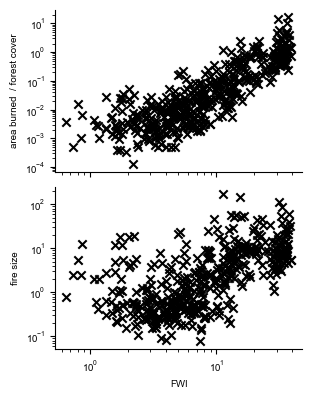

In [14]:
NUM_REGIONS = len(df_italy_matrix.columns)

YEARS = df_fwi.index
YEARS = YEARS[YEARS > 2002]
print(YEARS)

slopes = []
regions = df_italy_matrix.columns

regions = [('Italy', 'k'), ('Greece', None), ('Spain', None), ('Portugal', None)]

regions = [(c,  'k') for c in df_effis_area.columns[:-3]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(PAGE_WIDTH/2, 4), sharex=True)

style_plot(ax1)
style_plot(ax2)

# save figure
fig.tight_layout()

for region, color in regions:
    ax1.scatter(df_fwi_eu[region].values, df_effis_area[region] / df_units_eu['FORESTCOVER'][region], color=color, label=region, marker='x')
    ax2.scatter(df_fwi_eu[region].values, df_effis_area[region] / df_effis_number[region], color=color, label=region, marker='x')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('FWI')
ax1.set_ylabel('area burned  / forest cover')
ax2.set_ylabel('fire size')

fig.tight_layout()
savefig(fig, 'fwi_fire_correlation')

# FWI Linear Model

In [15]:
def print_metrics(errors, print_control=False):
    if print_control:
        for m, M in [('average:', np.average), ('std', np.std), ('rmse', lambda x : np.sqrt(np.mean(x**2)))]:
            print(f'{m} (CONTROL)' , (M(errors[CONTROL].dropna(axis=1).loc[YEARS_TRAIN].values),
            M(errors[CONTROL].dropna(axis=1).loc[YEARS_TEST].values),
            M(errors[CONTROL].dropna(axis=1).loc[YEARS_VAL].values)))
    
    for m, M in [('average:', np.average), ('std', np.std), ('rmse', lambda x : np.sqrt(np.mean(x**2)))]:
        print(f'{m} (TREATED)' , (M(errors[TREATED].dropna(axis=1).loc[YEARS_TRAIN].values),
        M(errors[TREATED].dropna(axis=1).loc[YEARS_TEST].values),
        M(errors[TREATED].dropna(axis=1).loc[YEARS_VAL].values)))
        
def aggr_errors(errors, regions, metric):
    return (metric(errors[regions].dropna(axis=1).loc[YEARS_TRAIN].values),
            metric(errors[regions].dropna(axis=1).loc[YEARS_TEST].values),
            metric(errors[regions].dropna(axis=1).loc[YEARS_VAL].values))

In [16]:
def linear_model(df_ab, df_features, years_train, log=False, df_flammable_surface=None, joint=False, huber=False, positive=False, fit_intercept=True):
    df_pred = df_ab.copy()

    if joint:
        X_train = []
        Y_train = []
        for region in df_ab.columns:
            X = pd.DataFrame([df[region] for df in df_features]).T
            Y = df_ab[region]
            if df_flammable_surface is not None:
                Y /= df_flammable_surface[region]
            if log:
                Y = np.log(Y)

            X_train.append(X.loc[years_train].values)
            Y_train.append(Y.loc[years_train].values)
        if huber:
            model = HuberRegressor(fit_intercept=fit_intercept).fit(np.concatenate(X_train), np.concatenate(Y_train))
        else:
            model = LinearRegression(fit_intercept=fit_intercept, positive=positive).fit(np.concatenate(X_train), np.concatenate(Y_train))
            


    for region in df_ab.columns:
        X = pd.DataFrame([df[region] for df in df_features]).T

        if not joint:
            Y = df_ab[region]
            if df_flammable_surface is not None:
                Y /= df_flammable_surface[region]
            if log:
                Y = np.log(Y)
            if huber:
                model = HuberRegressor(fit_intercept=fit_intercept).fit(X.loc[years_train].values, Y.loc[years_train].values)
            else:
                model = LinearRegression(fit_intercept=fit_intercept, positive=positive).fit(X.loc[YEARS_TRAIN].values, Y.loc[YEARS_TRAIN].values)
                # print(model, model.coef_ , model.intercept_, region)
            
        y_pred = model.predict(X.values) 

        if log:
            y_pred = np.exp(y_pred)
        if df_flammable_surface is not None:
            y_pred *= df_flammable_surface[region]

        df_pred[region] = y_pred
    return df_pred

linear_model(df_italy_matrix, [df_fwi], years_train=YEARS_TRAIN, log=False, df_flammable_surface=None, joint=True, huber=True)

,Abruzzo,Basilicata,Calabria,Campania,Emilia-Romagna,Friuli-Venezia Giulia,Lazio,Liguria,Lombardia,Marche,Molise,Piemonte,Puglia,Sardegna,Sicilia,Toscana,Umbria,Veneto
Year,,,,,,,,,,,,,,,,,,
2003,2167.501125,4289.434125,2444.329789,4167.943864,3086.266093,500.176191,4832.290020,1423.329761,1629.163732,3036.872624,2637.881930,2068.170672,5295.550349,6990.254627,4404.392835,4574.350674,5462.708189,1530.143862
2004,2173.188328,4355.838327,2821.653441,3638.937190,2271.491236,-772.182611,4080.365987,1062.133781,716.730151,2739.005612,3023.493582,1304.355485,5098.957160,6457.065242,4566.285223,3074.191778,4165.313022,386.818461
2005,775.233733,3867.141337,2589.136283,2393.117091,596.412915,-916.555852,2846.397734,-215.279166,-487.509840,974.482689,1598.894770,103.148129,4485.724274,5443.098010,5027.079325,1905.590320,2695.760207,-665.823197
2006,1198.306254,3190.136211,2349.900007,1783.661541,1346.577661,-8.645939,2366.032562,50.416474,555.331732,1733.137095,1638.579038,1127.161047,3833.871287,5334.444684,4619.177924,2383.038105,3294.930645,438.877974
2007,3518.264537,7473.768797,4719.172396,5400.058706,2743.053028,-673.756410,4625.325040,1269.051552,661.187877,4159.325554,5770.773432,1124.149879,8082.822858,6503.265288,6332.338500,3102.142416,4939.563806,42.549426
2008,2427.302192,6118.835444,3823.192616,4263.318266,1858.564384,-790.286704,4028.576444,34.036265,-379.704204,3689.745866,4065.242757,55.681381,7072.540076,5902.283543,5682.661519,2956.238500,4836.202285,-260.061355
2009,1144.642909,4172.652833,2967.203835,3296.004444,2002.129161,-439.695490,3017.861042,495.425785,397.599273,1593.540281,2225.695089,813.103675,4880.851926,5689.845068,4840.978919,3027.448957,3064.481018,416.185605
2010,897.164915,3596.548797,2293.907039,2198.991062,407.147228,-778.943610,2559.380954,-244.188117,-322.809024,1016.318698,2154.981255,-50.565374,4851.889130,5216.903878,4631.713837,1422.669918,2318.024987,-527.659980
2011,2004.109268,5132.292661,4119.951634,3759.819953,2758.464604,-471.838322,3211.140516,511.952106,-20.885363,3151.625046,3116.473484,402.764446,6195.057911,5735.720592,5636.835094,2715.864250,3337.344672,391.712183


# 3) Synthetic Control

In [17]:
def synthetic_control(X0, Y0, Phi0=None, joint_linear=True, verbose=False, convex_eq=True, constraint=1):
    """ 
        Computes synthetic control weights.
        
        Data control units pre-intervention:
        X0.shape = (num_features, num_control_units)
        
        Data treated units pre-intervention:
        Y0.shape = (num_features, num_treated_units)
        
        Computes argmin_w \\|X0 w - Y0 \\|_2    s.t.    w=probability vector
    """
   
    t, d = X0.shape
    _, n = Y0.shape
    w = cp.Variable((d, n))
    
    if Phi0 is None:
        cost = cp.sum_squares(X0 @ w - Y0)
    elif joint_linear:
        beta = cp.Variable(Phi0.shape[-1])
        cost = X0 @ w - Y0
        for i in range(Phi0.shape[2]):
            cost += Phi0[:,:,i] * beta[i]
        cost = cp.sum_squares(cost)
    else:
        beta = cp.Variable(Phi0.shape[-2:])
        cost = 0
        for j in range(Phi0.shape[1]):
            tmp_cost = X0 @ w[:, j] - Y0[:,j]
            
            for i in range(Phi0.shape[2]):
                tmp_cost += Phi0[:,j,i] * beta[j, i]
            cost += cp.sum_squares(tmp_cost)

    if convex_eq:
        prob = cp.Problem(cp.Minimize(cost), [cp.sum(w, axis=0) == constraint *  np.ones(n), w >= 0])
    else:
        prob = cp.Problem(cp.Minimize(cost), [cp.sum(w, axis=0) <= constraint * np.ones(n), w >= 0])
    prob.solve(verbose=verbose, max_iter=100000)
    
    # Print result.
    if verbose:
        print("\nThe optimal value is", prob.value)
        print("The optimal x is")
        print(w.value)
    if Phi0 is None:
        return w.value, None
    else:
        return w.value, beta.value

In [18]:
def apply_synthetic_control_loo(data, cols_control, cols_treated, t0, add_control_data=None, convex_eq=True, add_features=None, constraint=1):
    results  = []
    
    for col in cols_control:
        _cols_control = [c for c in cols_control if c != col]
        results.append(apply_synthetic_control(data, _cols_control, cols_treated, t0, add_control_data=add_control_data, convex_eq=convex_eq, add_features=add_features, constraint=constraint))
    return results

def apply_synthetic_control(data, cols_control, cols_treated, t0, add_control_data=None, verbose=False, add_features=None, joint_linear=True, return_weights=False, convex_eq=True, constraint=1):
    X0 = []
    Y0 = []
    Phi0 = [] if add_features is not None else None
    Phi = [] if add_features is not None else None

    for region in cols_control:
        features = []
        for df, weight in data:
            df_pre_intervention = df[df.index < t0] * weight
            features += df_pre_intervention[region].tolist()
        
        X0.append(features)
        
    for region in cols_treated:
        features = []
        for df, weight in data:
            df_pre_intervention = df[df.index < t0] * weight
            features += df_pre_intervention[region].tolist()
        
        Y0.append(features)
        if add_features is not None:
            Phi.append(add_features[region])
            
    X0 = np.array(X0).T
    Y0 = np.array(Y0).T


    if add_features is not None:
        Phi = np.array(Phi).swapaxes(0,1)
        Phi0 = Phi[:Y0.shape[0],:,:]
    
    if add_control_data is not None:
        df_add, weight_add = add_control_data
        X_add = df_add[cols_control].values * weight_add
        Y_add = df_add[cols_treated].values * weight_add
        X0 = np.vstack([X0, X_add])
        Y0 = np.vstack([Y0, Y_add])
    
    W, Beta = synthetic_control(X0, Y0, Phi0=Phi0, verbose=verbose, joint_linear=joint_linear, convex_eq=convex_eq, constraint=constraint)
    
    results = {}
    if Beta is not None:
        if joint_linear:
            for unit, w, phi in zip(cols_treated, W.T, Phi.swapaxes(0, 1)):        
                x1 = df[cols_control].values
                y1 = x1 @ w + phi@Beta
                results[unit] = y1
        else:
            for unit, w, phi, beta in zip(cols_treated, W.T, Phi.swapaxes(0, 1), Beta):        
                x1 = df[cols_control].values
                y1 = x1 @ w + phi@beta
                results[unit] = y1
            
    else:
        for unit, w in zip(cols_treated, W.T):        
            x1 = df[cols_control].values
            y1 = x1 @ w
            results[unit] = y1
        
    if return_weights:
        return pd.DataFrame(data=results,index=df.index.values.copy()), W, Beta
    return pd.DataFrame(data=results,index=df.index.values.copy())

In [19]:
def print_weights(results, threshold = 0.01):
    for unit in results['units_treated']:
        w = results[unit]['weights']
        mask = tuple([w >= threshold])
        print(f'{unit}: ' +', '.join([f"({r}, {wi:.2f})" for (r, wi) in zip(results['units_control'], w) if wi >= threshold]))

In [20]:
def grouped_bar_plot(data, periods, ax, colors={}, x=None):
    
    n_methods = len(data)
    if x is None:
        x = np.arange(len(periods))  # the label locations
    width = 1/(n_methods + 1)  # the width of the bars
    multiplier = 0

    for method, results in data.items():
        offset = width * multiplier - width * n_methods / 2 + width/2
        rects = ax.bar(x + offset, results, width, label=method, color=colors.get(method, None))
#         ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('RMSE')

    ax.set_xticks(x)
    ax.set_xticklabels(periods,)


In [21]:
data_effis_sc = {
    'area burned (ha)' : (df_effis_area, df_effis_area , 1),
    'average fire size (ha)' : (df_effis_area / df_effis_number, df_effis_area / df_effis_number, 1),
    'FWI' : (df_fwi_eu, df_fwi_eu, 0),
}


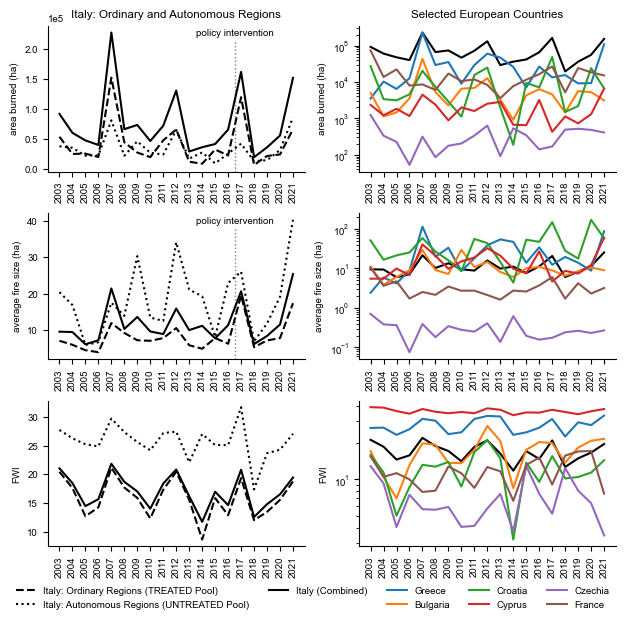

In [22]:
fig, axes = plt.subplots(len(data_effis_sc), 2, figsize=(PAGE_WIDTH, 6))

for (ax, ax2), (key, (data, data_normalized, add_policy_change)) in zip(axes, data_effis_sc.items()):


    ax.plot(YEARS, data['Italy TREATED'].values, label='Italy: Ordinary Regions (TREATED Pool)', color='k', linestyle='--')
    ax.plot(YEARS, data['Italy CONTROL'].values, label='Italy: Autonomous Regions (UNTREATED Pool)', color='k', linestyle=':')

    ax2.plot(YEARS, data_normalized['Italy'].values, label='Italy (Combined)', color='k')
    # add an invisible line to move labels to the right
    ax.plot(YEARS, data['Italy'].values, label='Italy (Combined)', color='k')
    # invisible line to shift labels 
    # ax.plot(YEARS, data_normalized['Italy TREATED'].values, label='   ', color='white', linestyle='--', alpha=0, linewidth=1)
    ax.plot(YEARS, data_normalized['Italy TREATED'].values, label='  ', color='white', linestyle='--', alpha=0, linewidth=1)

    ax2.plot(YEARS, data_normalized['Greece'].values, label='Greece') 
    ax2.plot(YEARS, data_normalized['Bulgaria'].values, label='Bulgaria')
    ax2.plot(YEARS, data_normalized['Croatia'].values, label='Croatia')
    ax2.plot(YEARS, data_normalized['Cyprus'].values, label='Cyprus')
    ax2.plot(YEARS, data_normalized['Czechia'].values, label='Czechia')
    # ax2.plot(YEARS, data_normalized['Slovakia'].values, label='Slovakia')
    # ax2.plot(YEARS, data_normalized['Spain'].values, label='Spain')
    ax2.plot(YEARS, data_normalized['France'].values, label='France')
    ax2.set_yscale('log')
    # ax2.plot(YEARS, data_normalized['Portugal'].values, label='Portugal')
    ax.set_ylabel(key)
    ax.set_xticks(YEARS)
    # rotate ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

    ax2.set_ylabel(key)
    ax2.set_xticks(YEARS)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='center')
    # ax.legend()
    style_plot(ax, add_policy_change=add_policy_change)
    style_plot(ax2)

axes[0,0].set_title('Italy: Ordinary and Autonomous Regions')
axes[0,1].set_title('Selected European Countries')

axes[0,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axes[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


# Collect unique legend handles and labels
handles, labels = [], []
for ax in axes.flatten():
    for h, l in zip(*ax.get_legend_handles_labels()):
        
        if l not in labels:  # Avoid duplicates
            labels.append(l)
            handles.append(h)


# Create a single legend below all subplots
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=False)

# Adjust layout
# fig.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom for legend

fig.tight_layout()
# fig.savefig(f'../plots/{timestamp}/{name}.png', dpi=300)
savefig(fig, 'fire_activity_italy')

In [23]:
COLS = ['Italy', 
        'Portugal', 
        'Spain', 
        'France', 
        'Greece', 
        'Austria', 
        'Bulgaria',
       'Croatia', 
       'Cyprus', 
       'Czechia', 
    #    'Estonia', 
    #    'Finland', 
       'Germany',
       'Hungary', 
    #    'Latvia', 
    #    'Lithuania', 
    #    'Norway', 
       'Poland', 
       'Romania',
       'Slovakia', 
       'Slovenia', 
    #    'Sweden', 
       'Switzerland', 
       'Türkiye',
       'Italy TREATED', 
       'Italy CONTROL']

df_mean_activity = df_effis_area[COLS].loc[YEARS_TRAIN].mean(axis=0)
df_mean_fire_size = (df_effis_area[COLS] / df_effis_number[COLS]).loc[YEARS_TRAIN].mean(axis=0)

data_effis_sc = {
    'area burned (ha)' : (df_effis_area[COLS] / df_units_eu['FORESTCOVER'][COLS], df_units_eu['FORESTCOVER'][COLS]),
    'average fire size (ha)' : (df_effis_area[COLS] / df_effis_number[COLS], 1),
}

Target: Italy TREATED


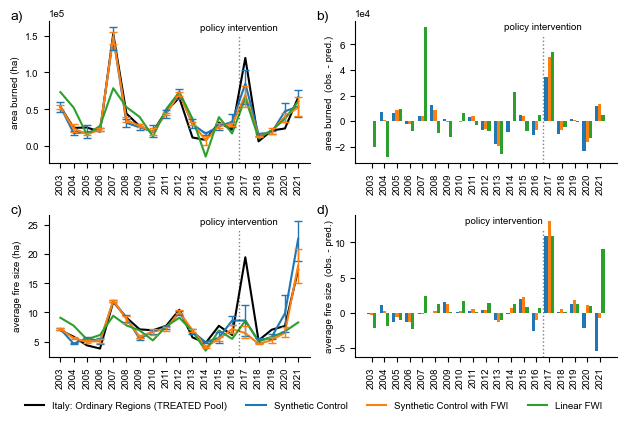

RMSE Summary:


,model,variable,2003-2014,2015-2016,2003-2016,2017,2018-2021,2017-2021
0,Synthetic Control,area burned (ha),7806.2,8543.3,7915.7,34974.9,14016.9,20045.6
1,Synthetic Control + FWI,area burned (ha),6995.8,5838.3,6842.5,50258.3,10862.2,24486.1
2,Linear FWI,area burned (ha),26170.8,6218.7,24343.2,54324.1,7363.6,25171.4
3,Synthetic Control,average fire size (ha),0.8,2.3,1.2,10.9,2.9,5.5
4,Synthetic Control + FWI,average fire size (ha),0.7,1.7,0.9,13.0,1.2,5.9
5,Linear FWI,average fire size (ha),1.6,0.7,1.5,10.9,4.6,6.4


Model Metrics Summary:


,model,variable,r2_pre,r2_post,dw_pre,lb-1_pre_pvalues,lb-2_pre_pvalues,lb-3_pre_pvalues
0,Synthetic Control,area burned (ha),0.95,0.76,1.30,0.20,0.44,0.16
1,Synthetic Control + FWI,area burned (ha),0.96,0.65,1.73,0.67,0.56,0.22
2,Linear FWI,area burned (ha),0.52,0.63,2.32,0.43,0.73,0.69
3,Synthetic Control,average fire size (ha),0.72,0.11,2.21,0.17,0.24,0.33
4,Synthetic Control + FWI,average fire size (ha),0.82,-0.02,1.97,0.82,0.18,0.28
5,Linear FWI,average fire size (ha),0.54,-0.18,1.47,0.42,0.27,0.41


Weights Summary (all rows):
---------------------
Synthetic Control :  area burned (ha)
absolute weights:
Bulgaria: 0.50
Croatia: 0.33
Greece: 0.16
Portugal: 0.00 

relative weights:
Greece: 0.31
Croatia: 0.29
Bulgaria: 0.18
Portugal: 0.04
---------------------

---------------------
Synthetic Control + FWI :  area burned (ha)
absolute weights:
Bulgaria: 0.69
Croatia: 0.19
Greece: 0.12
Portugal: 0.00 

relative weights:
Bulgaria: 0.25
Greece: 0.23
Croatia: 0.17
Portugal: 0.03
---------------------

---------------------
Synthetic Control :  average fire size (ha)
absolute weights:
Slovakia: 0.23
Türkiye: 0.20
Czechia: 0.20
France: 0.17 

relative weights:
Cyprus: 0.31
Türkiye: 0.11
Croatia: 0.09
Bulgaria: 0.08
---------------------

---------------------
Synthetic Control + FWI :  average fire size (ha)
absolute weights:
Czechia: 0.65
Türkiye: 0.13
Cyprus: 0.11
Bulgaria: 0.06 

relative weights:
Cyprus: 0.26
Bulgaria: 0.10
Türkiye: 0.07
Czechia: 0.03
---------------------

Target: Ital

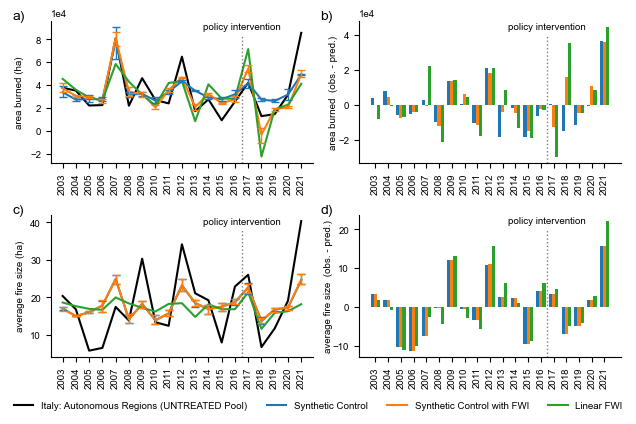

RMSE Summary:


,model,variable,2003-2014,2015-2016,2003-2016,2017,2018-2021,2017-2021
0,Synthetic Control,area burned (ha),10455.3,13758.1,10988.1,478.7,20573.2,18402.5
1,Synthetic Control + FWI,area burned (ha),9001.8,10671.8,9258.9,12271.4,20676.4,19290.7
2,Linear FWI,area burned (ha),13936.8,13574.0,13885.6,29434.5,28943.7,29042.6
3,Synthetic Control,average fire size (ha),7.0,7.4,7.1,3.3,9.0,8.2
4,Synthetic Control + FWI,average fire size (ha),7.0,7.4,7.1,3.4,9.0,8.2
5,Linear FWI,average fire size (ha),8.0,7.6,7.9,4.7,11.6,10.6


Model Metrics Summary:


,model,variable,r2_pre,r2_post,dw_pre,lb-1_pre_pvalues,lb-2_pre_pvalues,lb-3_pre_pvalues
0,Synthetic Control,area burned (ha),0.65,0.52,2.65,0.11,0.15,0.27
1,Synthetic Control + FWI,area burned (ha),0.76,0.47,2.52,0.24,0.47,0.52
2,Linear FWI,area burned (ha),0.45,-0.20,2.61,0.17,0.26,0.19
3,Synthetic Control,average fire size (ha),0.22,0.52,1.62,0.50,0.60,0.50
4,Synthetic Control + FWI,average fire size (ha),0.22,0.51,1.63,0.50,0.61,0.50
5,Linear FWI,average fire size (ha),0.03,0.19,1.89,0.90,0.73,0.89


Weights Summary (all rows):
---------------------
Synthetic Control :  area burned (ha)
absolute weights:
Greece: 0.63
Croatia: 0.35
Portugal: 0.02
Cyprus: -0.00 

relative weights:
Greece: 0.26
Croatia: 0.07
Portugal: 0.03
Austria: -0.00
---------------------

---------------------
Synthetic Control + FWI :  area burned (ha)
absolute weights:
Greece: 0.55
Spain: 0.43
Portugal: 0.02
Croatia: -0.00 

relative weights:
Greece: 0.22
Spain: 0.10
Portugal: 0.03
Austria: -0.00
---------------------

---------------------
Synthetic Control :  average fire size (ha)
absolute weights:
Spain: 0.84
Greece: 0.08
Portugal: 0.08
Croatia: 0.00 

relative weights:
Spain: 0.34
Greece: 0.14
Portugal: 0.02
Croatia: 0.00
---------------------

---------------------
Synthetic Control + FWI :  average fire size (ha)
absolute weights:
Spain: 0.84
Greece: 0.08
Portugal: 0.08
Croatia: 0.00 

relative weights:
Spain: 0.34
Greece: 0.14
Portugal: 0.02
Croatia: 0.00
---------------------



In [24]:
weights = {}
table = {}

SPLITS = [YEARS_TRAIN, YEARS_TEST, YEARS_TRAIN + YEARS_TEST, [2017], YEARS_VAL[1:], YEARS_VAL]
SPLITS_R2 = [YEARS_TRAIN + YEARS_TEST, YEARS_VAL]
SPLIT_YEARS = [[y] for y in YEARS]

CONFIGS = [
    {
        'file' : 'synthetic_control_ordinary',
        'target' : 'Italy TREATED',
        'title' : 'Italy: Ordinary Regions (TREATED Pool)',
        'loo' : True,
        'fwi' : True,
        'linear' : True
    },
    {
        'file' : 'synthetic_control_autonomous',
        'target' : 'Italy CONTROL',
        'title' : 'Italy: Autonomous Regions (UNTREATED Pool)',
        'loo' : True,
        'fwi' : True,
        'linear' : True
    },
]


for config in CONFIGS:
    print(f"Target: {config['target']}")
    RMSE = []
    R2 = {}

    # New collectors
    metrics_summary = []
    weights_summary = []

    TARGET = config['target']
    fig, _axes = plt.subplots(2, len(data_effis_sc), figsize=(PAGE_WIDTH, 4))
    axes, axes2 = _axes.T

    for ax, ax2, (key, (data, df_norm)) in zip(axes, axes2, data_effis_sc.items()):
        mean_data = data.loc[YEARS_TRAIN].mean(axis=0)

        bar_plot_data = {}
        # controls
        controls= [c for c in data.columns if c not in ['Italy', 'Italy TREATED', 'Italy CONTROL', TARGET]]

        # Observed
        df_obs = data
        if 'log' in key:
            df_obs = np.exp(df_obs)

        ax.plot(YEARS, (df_obs * df_norm)[TARGET].values, color='k', linestyle='-', label=config['title'])

        # Plain SC
        add_features = {TARGET: np.ones((1, len(YEARS)))}
        df_sc, W, Beta = apply_synthetic_control(
                data=[(data, 1.),] ,
                cols_control=controls,
                cols_treated=[TARGET],
                t0=YEARS_TEST[0],
                add_control_data=None,
                return_weights=True,
                convex_eq=False,
                add_features=add_features
        )

        if 'log' in key:
            df_sc = np.exp(df_sc)

        ax.plot(YEARS, (df_sc * df_norm)[TARGET].values, linestyle='-', label='Synthetic Control', color='C0')
        bar_plot_data['Synthetic Control'] = (data * df_norm - df_sc * df_norm)[TARGET]

        # RMSE
        RMSE.append(((TARGET, key,'Synthetic Control'), get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)))

        # R2
        r2 = get_r2(df_sc * df_norm, data * df_norm, TARGET, SPLITS_R2)

        residuals = (df_sc * df_norm - data * df_norm)[TARGET]
        dw_train = durbin_watson_test(residuals.loc[YEARS_TRAIN].values)
        dw_train_test = durbin_watson_test(residuals.loc[YEARS_TRAIN + YEARS_TEST].values)
        lb_train = ljung_box_q_test(residuals.loc[YEARS_TRAIN].values)
        lb_train_test = ljung_box_q_test(residuals.loc[YEARS_TRAIN + YEARS_TEST].values)

        # Weights (absolute & relative)
        Z = W.flatten() * mean_data[controls].values / mean_data[TARGET]
        weights_summary.append(
            {
                'model': 'Synthetic Control',
                'variable': key,
                'absolute weights': ", ".join([f"{c}: {w.item():.2f}" for c, w in [*sorted(zip(controls, W), key=lambda x:-x[1])][:4]]),
                'relative weights': ", ".join([f"{z}: {w.item():.2f}" for z, w in [*sorted(zip(controls, Z), key=lambda x:-x[1])][:4]])
            }
        )

        metrics_summary.append({
            'model': 'Synthetic Control',
            'variable': key,
            'r2_pre': r2[0],
            'r2_post': r2[1],
            # 'dw_train': dw_train,
            'dw_pre': dw_train_test,
            # 'lb-1_train_pvalues': lb_train[0],
            # 'lb-2_train_pvalues': lb_train[1],
            # 'lb-3_train_pvalues': lb_train[2],
            'lb-1_pre_pvalues': lb_train_test[0],
            'lb-2_pre_pvalues': lb_train_test[1],
            'lb-3_pre_pvalues': lb_train_test[2],
            # 'beta': None
        })

        # SC + FWI
        if config['fwi']:
            add_data = pd.DataFrame({
                'FWI' : df_fwi_eu[TARGET] if not 'log' in key else np.log(df_fwi_eu[TARGET]),
            })
            add_data['C'] = 1
            add_features = {TARGET: add_data.loc[YEARS].values}

            df_sc_fwi, W_fwi, Beta_fwi = apply_synthetic_control(
                    data=[(data, 1.),] ,
                    cols_control=controls,
                    cols_treated=[TARGET],
                    t0=YEARS_TEST[0],
                    add_control_data=None,
                    return_weights=True,
                    convex_eq=False,
                    add_features=add_features,
            )

            if 'log' in key:
                df_sc_fwi = np.exp(df_sc_fwi)

            ax.plot(YEARS, (df_sc_fwi * df_norm)[TARGET].values, linestyle='-', label='Synthetic Control with FWI', color='C1')
            bar_plot_data['Synthetic Control + FWI'] = (data * df_norm - df_sc_fwi * df_norm)[TARGET]

            RMSE.append(((TARGET, key,'Synthetic Control + FWI'), get_rmse(df_sc_fwi * df_norm, data * df_norm, TARGET, SPLITS)))

            r2_fwi = get_r2(df_sc_fwi * df_norm, data * df_norm, TARGET, SPLITS_R2)
            R2[TARGET] = r2_fwi

            residuals_fwi = (df_sc_fwi * df_norm - data * df_norm)[TARGET]
            dw_train_fwi = durbin_watson_test(residuals_fwi.loc[YEARS_TRAIN].values)
            dw_train_test_fwi = durbin_watson_test(residuals_fwi.loc[YEARS_TRAIN + YEARS_TEST].values)
            lb_train_fwi = ljung_box_q_test(residuals_fwi.loc[YEARS_TRAIN].values)
            lb_train_test_fwi = ljung_box_q_test(residuals_fwi.loc[YEARS_TRAIN + YEARS_TEST].values)

            Z_fwi = W_fwi.flatten() * mean_data[controls].values / mean_data[TARGET]
            weights_summary.append(
                {
                    'model': 'Synthetic Control + FWI',
                    'variable': key,
                    'absolute weights': ", ".join([f"{c}: {w.item():.2f}" for c, w in [*sorted(zip(controls, W_fwi), key=lambda x:-x[1])][:4]]),
                    'relative weights': ", ".join([f"{z}: {w.item():.2f}" for z, w in [*sorted(zip(controls, Z_fwi), key=lambda x:-x[1])][:4]])
                }
            )

            # print("Absolute weights", ", ".join([f"{c}: {w.item():.2f}" for c, w in [*sorted(zip(controls, W), key=lambda x:-x[1])][:4]]))
            # print("Relative weights", ", ".join([f"{z}: {w.item():.2f}" for z, w in [*sorted(zip(controls, Z), key=lambda x:-x[1])][:4]]))

            metrics_summary.append({
                'model': 'Synthetic Control + FWI',
                'variable': key,
                'r2_pre': r2_fwi[0],
                'r2_post': r2_fwi[1],
                # 'dw_train': dw_train_fwi,
                'dw_pre': dw_train_test_fwi,
                # 'lb-1_train_pvalues': lb_train_fwi[0],
                # 'lb-2_train_pvalues': lb_train_fwi[1],
                # 'lb-3_train_pvalues': lb_train_fwi[2],
                'lb-1_pre_pvalues': lb_train_test_fwi[0],
                'lb-2_pre_pvalues': lb_train_test_fwi[1],
                'lb-3_pre_pvalues': lb_train_test_fwi[2],
                # 'beta': None if Beta_fwi is None else list(np.array(Beta_fwi).ravel())
            })

        # Linear FWI
        if config['linear']:
            df_linear_pred = linear_model(data[[TARGET]], [df_fwi_eu[[TARGET]]], log=False, years_train=YEARS_TRAIN, joint=False, huber=False)
            ax.plot(YEARS, (df_linear_pred * df_norm)[TARGET].values, linestyle='-', label='Linear FWI', color='C2')
            bar_plot_data['Linear FWI'] = (data * df_norm - df_linear_pred * df_norm)[TARGET]

            RMSE.append(((TARGET, key,'Linear FWI'), get_rmse(df_linear_pred * df_norm, data * df_norm, TARGET, SPLITS)))

            r2_lin = get_r2(df_linear_pred * df_norm, data * df_norm, TARGET, SPLITS_R2)
            residuals_lin = (df_linear_pred * df_norm - data * df_norm)[TARGET]
            dw_train_lin = durbin_watson_test(residuals_lin.loc[YEARS_TRAIN].values)
            dw_train_test_lin = durbin_watson_test(residuals_lin.loc[YEARS_TRAIN + YEARS_TEST].values)
            lb_train_lin = ljung_box_q_test(residuals_lin.loc[YEARS_TRAIN].values)
            lb_train_test_lin = ljung_box_q_test(residuals_lin.loc[YEARS_TRAIN + YEARS_TEST].values)

            metrics_summary.append({
                'model': 'Linear FWI',
                'variable': key,
                'r2_pre': r2_lin[0],
                'r2_post': r2_lin[1],
                # 'dw_train': dw_train_lin,
                'dw_pre': dw_train_test_lin,
                # 'lb-1_train_pvalues': lb_train_lin[0],
                # 'lb-2_train_pvalues': lb_train_lin[1],
                # 'lb-3_train_pvalues': lb_train_lin[2],
                'lb-1_pre_pvalues': lb_train_test_lin[0],
                'lb-2_pre_pvalues': lb_train_test_lin[1],
                'lb-3_pre_pvalues': lb_train_test_lin[2],
                # 'beta': None  # not captured from sklearn linear regression (could be added)
            })

        # LOO
        if config['loo']:
            add_features = {TARGET: np.ones((1, len(YEARS)))}
            res_loo = apply_synthetic_control_loo(
                    data=[(data, 1.),] ,
                    cols_control=controls,
                    cols_treated=[TARGET],
                    t0=YEARS_TEST[0],
                    convex_eq=True,
                    add_features=add_features
            )

            res_loo = np.array([(r * df_norm)[TARGET] for r in res_loo])
            mean_loo = np.mean(res_loo, axis=0)
            std_loo = np.std(res_loo, axis=0, ddof=1)
            z_value = 1.96
            ax.errorbar(YEARS, mean_loo, yerr=z_value * std_loo, color='C0', capsize=3, linestyle='', linewidth=1)

            if config['fwi']:
                add_data = pd.DataFrame({
                                'FWI' : df_fwi_eu[TARGET] if not 'log' in key else np.log(df_fwi_eu[TARGET]),
                })
                add_data['C'] = 1
                add_features = {TARGET: add_data.loc[YEARS].values}
                res_loo = apply_synthetic_control_loo(
                        data=[(data, 1.),] ,
                        cols_control=controls,
                        cols_treated=[TARGET],
                        t0=YEARS_TEST[0],
                        convex_eq=True,
                        add_features=add_features
                )

                res_loo = np.array([(r * df_norm)[TARGET] for r in res_loo])
                mean_loo_fwi = np.mean(res_loo, axis=0)
                std_loo_fwi = np.std(res_loo, axis=0, ddof=1)
                ax.errorbar(YEARS, mean_loo_fwi, yerr=z_value * std_loo_fwi, color='C1', capsize=3, linestyle='', linewidth=1)

        ax.set_xticks(YEARS)
        ax.set_ylabel(key)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
        style_plot(ax, add_policy_change=True)

        grouped_bar_plot(bar_plot_data, [str(y) for y in YEARS], ax2, x=YEARS)
        ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
        ax2.set_ylabel(key[:-4] + ' (obs. - pred.)', labelpad=0)
        style_plot(ax2, add_policy_change=True, ha='right' if config['file'] == 'synthetic_control_ordinary' and key == 'average fire size (ha)' else 'center')

    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axes2[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    handles, labels = [], []
    for ax in axes.flatten():
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                labels.append(l)
                handles.append(h)

    fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

    for i, ax in enumerate(_axes.flatten()):
        ax.text(-0.1, 1.07, chr(97 +i) + ')', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right')

    fig.subplots_adjust()
    fig.tight_layout()
    savefig(fig, config['file'])
    plt.show()

    # RMSE table
    print("RMSE Summary:")
    rmse_data = []
    for (data_id, rmse) in RMSE:
        rmse_data.append([data_id[2], data_id[1], *[f"{r:.1f}" for r in rmse]])
    df_rmse = pd.DataFrame(rmse_data, columns=['model', 'variable', '2003-2014', '2015-2016', '2003-2016', '2017', '2018-2021', '2017-2021'])
    display(df_rmse)

    print("Model Metrics Summary:")
    df_metrics_summary = pd.DataFrame(metrics_summary)
    display(df_metrics_summary.style.format(precision=2))

    print("Weights Summary (all rows):")
    # df_weights_summary = pd.DataFrame(weights_summary)
    # display(weights_summary)
    for row in weights_summary:
        print('---------------------')
        print(row['model'], ': ', row['variable'])
        print('absolute weights:')
        print(row['absolute weights'].replace(', ', '\n'), '\n')
        print('relative weights:')
        print(row['relative weights'].replace(', ', '\n'))
        print('---------------------\n')
    
# Provide also per-model average weights (optional, derived; logic unchanged for core computations)
# avg_weights = df_weights_summary.groupby(['target','variable','model'])[['absolute_weight','relative_weight']].mean().reset_index()
# display(avg_weights)


In [25]:
data_effis_sc = {
    'normalized area burned' : (df_effis_area / df_units_eu['FORESTCOVER'], df_units_eu['FORESTCOVER']),
    'average fire size' : (df_effis_area / df_effis_number, 1),
}

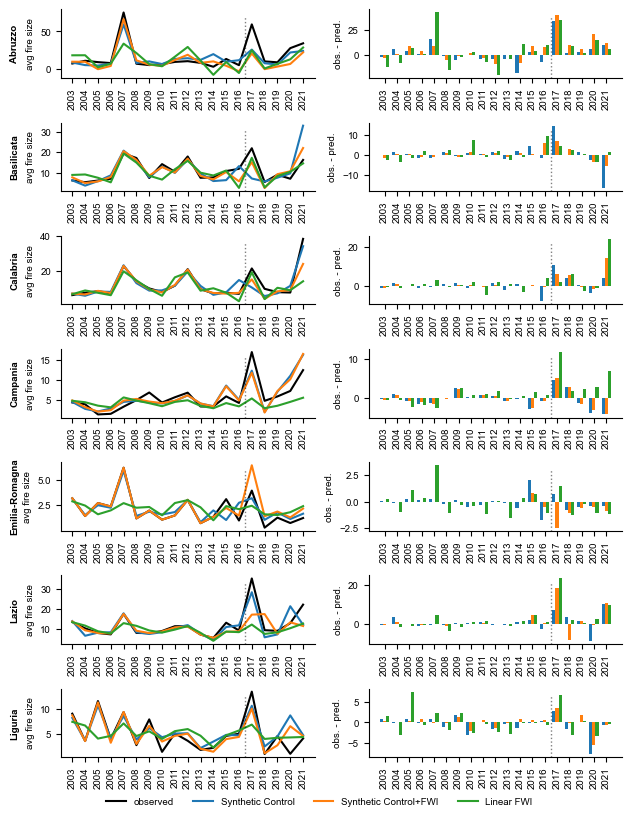

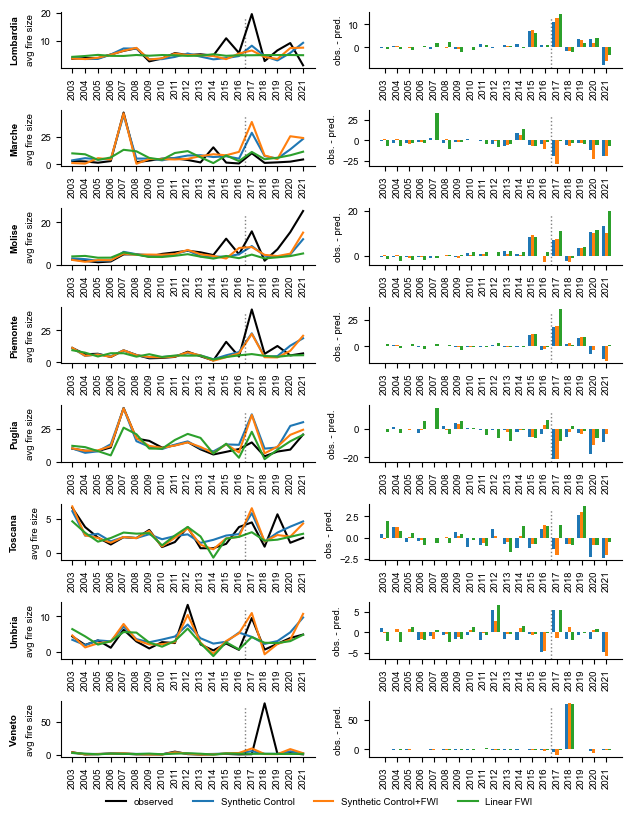

In [26]:
df_italy = df_italy_matrix / df_units['FORESTCOVER']
df_europe = df_effis_area / df_units_eu['FORESTCOVER']
metric = 'area burned'


df_italy = df_italy_matrix / df_italy_num_fires
df_europe = df_effis_area / df_effis_number
metric = 'avg fire size'

df_italy_treated = df_italy[TREATED].copy()
# add suffix to treated regions

df_combined = pd.concat([df_italy_treated, df_europe.drop(columns=['Italy', 'Italy TREATED', 'Italy CONTROL'])], axis=1)


treated_sorted = sorted(df_italy_treated.columns.values)

predictions = []

for part, treated in enumerate([treated_sorted[:7], treated_sorted[7:]]):

    fig, axes = plt.subplots(len(treated), 2, figsize=(1.*PAGE_WIDTH, 8), sharex=False)
    control = [c for c in df_combined.columns if c not in treated and not 'Italy' in c]

    for i, (region, (ax, ax2)) in enumerate(zip(treated, axes)):

        bar_plot_data ={}
        ax.plot(YEARS, df_italy_treated[region].values, color=f'k', linestyle='-', label='observed')
        df_sc = apply_synthetic_control(
            data=[(df_combined, 1.),] ,
            cols_control=control, 
            cols_treated=[region],
            t0=YEARS_TEST[0],
            add_control_data=None,
        )

        ax.plot(YEARS, df_sc[region].values, linestyle='-', label='Synthetic Control')
        bar_plot_data['Synthetic Control'] = (df_italy_treated[region] - df_sc[region]) #get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)

        add_data = pd.DataFrame({
                'FWI' : df_fwi[region], 
                #  'FWI_LOG' : np.log(df_fwi_eu[TARGET])
                })
        add_data['C'] = 1
        add_features = dict()
        add_features[region] = add_data.loc[YEARS].values

        df_sc = apply_synthetic_control(
            data=[(df_combined, 1.),] ,
            cols_control=control, 
            cols_treated=[region],
            t0=YEARS_TEST[0],
            add_control_data=None,
            add_features=add_features
        )

        predictions.append(df_sc)

        ax.plot(YEARS, df_sc[region].values, linestyle='-', label='Synthetic Control+FWI')

        bar_plot_data['Synthetic Control+FWI'] = (df_italy_treated[region] - df_sc[region]) #get_rmse(df_sc * df_norm, data * df_norm, TARGET, SPLITS)


        df_linear_pred = linear_model(df_combined[[region]], [df_fwi[[region]]], years_train=YEARS_TRAIN, joint=False, huber=False)
        ax.plot(YEARS, df_linear_pred[region].values, linestyle='-', label='Linear FWI', color='C2')
        bar_plot_data['Linear FWI'] = (df_italy_treated[region] - df_linear_pred[region])

        # ax.plot(YEARS, df_sc_results_log[region].values, linestyle='-', label='SC log')

        # ax.legend()
        # ax.set_title(region)
        # ax2.set_title(region)
        ax.set_xticks(YEARS)
        # rotate ticks
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=7)
        # ax.set_ylabel(metric)
        ax.text(s=region, rotation='vertical', x=-0.2, y=0.5, va='center', transform = ax.transAxes, weight='bold')
        ax.set_ylabel(metric)
        ax2.set_ylabel('obs. - pred.')
        style_plot(ax, add_policy_change='line')
        grouped_bar_plot(bar_plot_data, [str(y) for y in YEARS], ax2, x=YEARS)
        ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

        style_plot(ax2, add_policy_change='line')

    # Collect unique legend handles and labels
    handles, labels = [], []
    for ax in axes.flatten():
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:  # Avoid duplicates
                labels.append(l)
                handles.append(h)

    # for row in axes:
    #     row[0].set_ylabel(ylabel)
        
    # fig.suptitle(metric, fontsize=8)
    # Create a single legend below all subplots
    fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.02), frameon=False)

    # Adjust layout
    # fig.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom for legend

    fig.subplots_adjust()
    fig.tight_layout()
    savefig(fig, f'synthetic_control_regions_{part}_{metric}')
